In [3]:
# Author: Genevieve Mortensen, code helped by ChatGPT-4
# Date: 02/26/2024
# Purpose: Use LIME to explain the predictions of the best performing models.

In [4]:
import os
import pandas as pd
import numpy as np
import subprocess
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

/tmp/ipykernel_307538/1300250772.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
# Extract eGeMAPS features using OpenSMILE and save output to a CSV file, but also return the vector for embedding
def acoustic_features(audio_path, output_dir, opensmile_config_path):
    
    output_csv_path = os.path.join(output_dir, os.path.basename(audio_path).replace('.wav', '.csv'))
    # command = [
    #     "../opensmile-3.0.2-linux-x86_64/bin/SMILExtract",
    #     "-C", opensmile_config_path,
    #     "-I", audio_path,
    #     "-O", output_csv_path
    # ]

    # subprocess.run(command, check=True)
    with open(output_csv_path, 'r') as f:
        lines = f.readlines()
        data_start = lines.index('@data\n') + 1   # Read the CSV and return the data after '@data'
        data_lines = lines[data_start:]
        attribute_lines = [line for line in lines if line.startswith('@attribute')]
    attribute_list = [line.split(' ')[1].strip("'") for line in attribute_lines]
    attribute_list = attribute_list[1:-1]
    data_list = [line.strip().split(',') for line in data_lines if line.strip()]
    return data_list, attribute_list

In [6]:
#Extract acoustic features and return labels
def get_training_features(root_dir, output_dir, config_file):
    features_list = []
    labels = []

    for label_dir in ["cn", "ad"]:
        dir_path = os.path.join(root_dir, label_dir)
        for filename in os.listdir(dir_path):
            if filename.endswith(".wav"):
                audio_path = os.path.join(dir_path, filename)
                features, attributes = acoustic_features(audio_path, output_dir, config_file)
                features_list.append(features)
                labels.append(0 if label_dir == "cn" else 1)
                
    print("Training features and labels acquired")
    labels = np.array(labels)
    return features_list, labels, attributes

#Same with test
def get_test_features(test_root_dir, test_labels_path, output_dir, config_file):
    features_list = []
    file_ids = []
    labels = []
    test_labels_df = pd.read_csv(test_labels_path, header=None)

    label_mapping = {'CN': 0, 'AD': 1}
    test_labels_df['label'] = test_labels_df.iloc[:, 1].map(label_mapping)
    test_labels_df['label'] = test_labels_df['label'].fillna(-1).astype(int)
    file_label_dict = pd.Series(test_labels_df['label'].values, index=test_labels_df.iloc[:, 0].astype(str).str.strip()).to_dict()

    for filename in os.listdir(test_root_dir):
        if filename.endswith(".wav"):
            file_id = filename.split('.')[0].strip()
            audio_path = os.path.join(test_root_dir, filename)
            features, attributes = acoustic_features(audio_path, output_dir, config_file)
            features_list.append(features)
            file_ids.append(file_id)
            # -1 means we don't have a label for the file and our binary classifiers won't work
            label = file_label_dict.get(file_id, -1)
            labels.append(label)
            if label == -1:
                print(f"Label missing for file_id: {file_id}")

    labels = np.array(labels)
    print("Testing features, file identifiers, and labels acquired")
    return features_list, file_ids, labels, attributes

In [7]:
def preprocess_features(feature_vectors):
    processed_vectors = []
    for vector_wrapper in feature_vectors:
        vector = vector_wrapper[0]  # Extract the actual feature vector
        processed_vector = [float(feature) for feature in vector if feature not in ['unknown', '?']]
        processed_vectors.append(processed_vector)
    return np.array(processed_vectors, dtype=object)  # Use dtype=object to accommodate arrays of different lengths

In [8]:
def lr_classifier(train_embeddings, labels):
    # Scale the embeddings
    train_embeddings_scaled, _ = scale_features(train_embeddings, train_embeddings)  # Dummy call for scaling
    
    # Rest of the training logic
    log_reg = LogisticRegression(solver='liblinear')
    param_grid = {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100]
    }
    
    grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', verbose=1)
    grid_search.fit(train_embeddings_scaled, labels)
    print(f"Best hyperparameters: {grid_search.best_params_}")
    
    best_model = grid_search.best_estimator_
    
    # Return a prediction function that applies the same scaling to input data
    def predict_fn(data):
        _, data_scaled = scale_features(train_embeddings, data)  # Only need the scaled test data
        return best_model.predict_proba(data_scaled)
    
    return predict_fn


In [9]:
from sklearn.preprocessing import StandardScaler

def scale_features(train_embeddings, test_embeddings):
    scaler = StandardScaler()
    train_embeddings_scaled = scaler.fit_transform(train_embeddings)
    test_embeddings_scaled = scaler.transform(test_embeddings)
    
    return train_embeddings_scaled, test_embeddings_scaled

In [10]:
def xgboost_classifier(train_embeddings, labels):
    # Apply feature scaling
    scaler = StandardScaler()
    train_embeddings_scaled = scaler.fit_transform(train_embeddings)
    
    xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    param_grid = {
        'max_depth': [3, 4, 5],
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2]
    }
    
    grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='f1', verbose=1)
    grid_search.fit(train_embeddings_scaled, labels)
    print(f"Best XGB hyperparameters: {grid_search.best_params_}")
    
    best_model = grid_search.best_estimator_
    
    # Return a prediction function that applies the same scaling
    def predict_fn(data):
        data_scaled = scaler.transform(data)  # Apply scaling to new data
        return best_model.predict_proba(data_scaled)
    
    return predict_fn

In [11]:
from lime import lime_tabular

def lime_explainer(training_data, testing_data, attributes, predict_fn, class_names=['Non-AD', 'AD']):
    # Instantiate LimeTabularExplainer
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=training_data,  # Example training data
        feature_names=attributes,  # Names of the audio features
        class_names=class_names,
        mode='classification'
    )

    explanations = [] 
    # Iterate over each instance in the testing data
    for i, data_row in enumerate(testing_data):
        exp = explainer.explain_instance(
            data_row=data_row,
            predict_fn=predict_fn
        )
        explanations.append(exp)
        # exp.show_in_notebook(show_table=True)
        # For non-notebook environments, consider using exp.save_to_file('explanation_{}.html'.format(i))
    
    return explanations

In [12]:
def aggregate_feature_importances(explanations, attributes):
    # Initialize a dictionary to hold the sum of feature importances with feature names as keys
    feature_importance_sum = {feature: 0.0 for feature in attributes}
    
    # Iterate over each explanation
    for exp in explanations:
        # Get the feature importances from the explanation
        # exp.as_list() returns a list of tuples: (feature_name, importance_score)
        for feature, importance in exp.as_list():
            if feature in feature_importance_sum:
                feature_importance_sum[feature] += abs(importance)  # Use absolute value to consider overall impact
            else:
                # Handle the case where a feature is found in the explanation but was not initialized
                feature_importance_sum[feature] = abs(importance)
    
    # Sort features by their accumulated importance
    sorted_features = sorted(feature_importance_sum.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_features


import matplotlib.pyplot as plt

def visualize_top_features(sorted_features, top_n=20):
    # Extract the top N features and their importances
    top_features = sorted_features[:top_n]
    feature_names = [f"Feature {feature}" for feature, _ in top_features]
    importances = [importance for _, importance in top_features]
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(feature_names, importances, color='skyblue')
    plt.xlabel('Aggregate Importance')
    plt.ylabel('Features')
    plt.title('Top 20 Important Features for AD Predictions')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.show()

Training features and labels acquired
Testing features, file identifiers, and labels acquired
[[35.3146 0.2358319 29.96552 ... 0.2171845 0.3432128 -28.57728]
 [20.42863 0.3032279 13.74936 ... 0.06593496 0.05665239 -19.48851]
 [26.41714 0.3968872 17.39483 ... 0.3567123 0.7596431 -21.02871]
 ...
 [34.07787 0.2206853 30.91345 ... 0.3258065 0.5385062 -24.47795]
 [31.38127 0.4690389 17.6969 ... 0.3692683 0.642997 -33.24164]
 [37.92628 0.3360026 28.18277 ... 0.67 1.298301 -33.36269]]
['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2', 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean', 'loudness_sma3_stddevNorm', 'loudness_

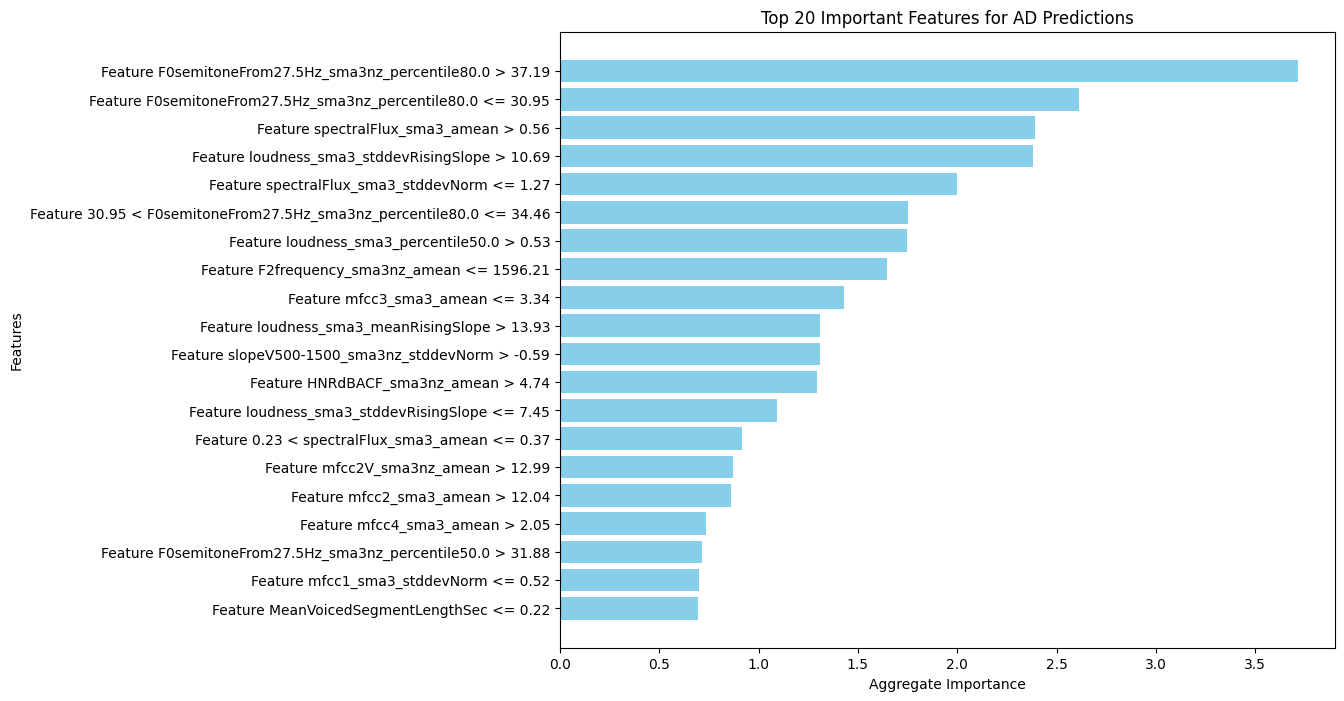

In [13]:
if __name__ == '__main__':

    # Get the goods (acoustic features) - This part takes 10-15 minutes to run.
    output_dir = "/home/gamorten/privacyLLM/Healthcare-Chatbots/openSMILE_outputs"
    config_file = "/home/gamorten/privacyLLM/Healthcare-Chatbots/opensmile-3.0.2-linux-x86_64/config/egemaps/v02/eGeMAPSv02.conf"
        # training data
    root_dir = '/home/gamorten/privacyLLM/Healthcare-Chatbots/ADReSSo21/diagnosis/train/audio'
    training_features, labels, attributes = get_training_features(root_dir, output_dir, config_file)
         # testing data
    test_root_dir = '/home/gamorten/privacyLLM/Healthcare-Chatbots/ADReSSo21/diagnosis/test-dist/audio'
    test_labels_path = '/home/gamorten/privacyLLM/Healthcare-Chatbots/groundtruth/task1.csv'
    test_features, test_file_ids, test_labels, attributes = get_test_features(test_root_dir, test_labels_path, output_dir, config_file)

    # Need to preprocess features for classifier input
    training_features_num = preprocess_features(training_features)
    test_features_num = preprocess_features(test_features)
    print(training_features_num)
    # attributes = acoustic_features(root_dir, output_dir, config_file)
    print(attributes)

    predict_fn_lr = lr_classifier(training_features_num, labels)
    predict_fn_xgb = xgboost_classifier(training_features_num, labels)
    # Generate explanations as before
    explanations_lr = lime_explainer(training_features_num, test_features_num, attributes, predict_fn_lr)
    explanations_xgb = lime_explainer(training_features_num, test_features_num, attributes, predict_fn_xgb)

    # # Aggregate feature importances
    # sorted_features_lr_21 = aggregate_feature_importances(explanations_lr, attributes)
    # sorted_features_xgb_21 = aggregate_feature_importances(explanations_xgb, attributes)
    sorted_features_lr_20 = aggregate_feature_importances(explanations_lr, attributes)
    sorted_features_xgb_20 = aggregate_feature_importances(explanations_xgb, attributes)
    
    # # Visualize the top N features
    visualize_top_features(sorted_features_xgb_21, top_n=20)